In [1]:
!pip install mxnet-cu100

In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt

ctx = mx.gpu()

#Getting MNIST dataset

In [0]:
def transform(data, label):
    return data.reshape((784)).astype('float32')/255.0, label.astype('float32')

train_mnist = gluon.data.vision.datasets.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.datasets.MNIST(train = False, transform = transform)

In [4]:
image, label = train_mnist[5]
image.shape, label.shape

((784,), ())

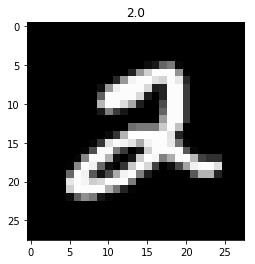

In [5]:
plt.imshow(image.reshape((28, 28)).asnumpy(), cmap = 'gray')
plt.title(label)
plt.show()

In [0]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size, True)
test_data = gluon.data.DataLoader(test_mnist, batch_size, False)

##Initializing model parameters and batch normal parameters

In [0]:
weight_scale = .01

#  Allocate parameters for the first hidden layer
W1 = nd.random_normal(shape = (784, 256), scale = weight_scale, ctx = ctx)
b1 = nd.random_normal(shape = 256, scale = weight_scale, ctx = ctx)
gamma1 = nd.random_normal(shape = 256, scale = weight_scale, ctx = ctx)
beta1 = nd.random_normal(shape = 256, scale = weight_scale, ctx = ctx)


#  Allocate parameters for the second hidden layer
W2 = nd.random_normal(shape = (256, 128), scale = weight_scale, ctx = ctx)
b2 = nd.random_normal(shape = 128, scale = weight_scale, ctx = ctx)
gamma2 = nd.random_normal(shape = 128, scale = weight_scale, ctx = ctx)
beta2 = nd.random_normal(shape = 128, scale = weight_scale, ctx = ctx)

#  Allocate parameters for the output layer
W3 = nd.random_normal(shape=(128, 10), scale = weight_scale, ctx = ctx)
b3 = nd.random_normal(shape=10, scale = weight_scale, ctx = ctx)

params = [W1, b1, gamma1, beta1, W2, b2, gamma2, beta2, W3, b3]

for param in params:
    param.attach_grad()

##Defining Layer Norm Layer

In [0]:
def layernorm(layer, gamma, beta):
    mean = nd.mean(layer, axis = 1, keepdims = True)
    variance = nd.mean((layer - mean) ** 2, axis=1, keepdims = True)
    layer_hat = (layer - mean) * 1.0 / nd.sqrt(variance + 1e-8)
    out = gamma * layer_hat + beta
    
    return out

In [0]:
def relu(x):
    return nd.maximum(x, 0)

In [0]:
def softmax(linear):
    exp = nd.exp(linear - nd.max(linear))
    partition = nd.sum(exp).reshape((-1, 1))
    return exp / partition

##Building the model

In [0]:
def model(inputs):
    layer1 = layernorm(nd.relu(nd.dot(inputs, W1) + b1), gamma1, beta1)
    layer2 = layernorm(nd.relu(nd.dot(layer1, W2) + b2), gamma2, beta2)
    return nd.softmax(nd.dot(layer2, W3) + b3)

In [12]:
for data, _ in train_data:
    data = data.as_in_context(ctx)
    break
    
print(data.shape)
output = model(data)
print(output.shape)

(64, 784)
(64, 10)


In [0]:
def categoricalcrossentropy(pred, label):
    return -nd.sum(label * nd.log(pred))

In [0]:
def sgd(params, lr):
    for param in params:
        param[:] = param - lr * param.grad

In [0]:
def accuracy(predictions, labels):
    return nd.mean(predictions.argmax(1) == labels.argmax(1))

##Training the model

In [16]:
epochs = 10
num_batches = 60000/batch_size
learning_rate = .001
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    cumulative_acc = 0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx).one_hot(10)
        with autograd.record():
            output = model(features)
            loss = categoricalcrossentropy(output, labels)
        loss.backward()
        sgd(params, learning_rate)
        cumulative_loss += loss
        cumulative_acc += accuracy(output, labels)
    loss = cumulative_loss.asscalar()/num_batches
    cc = cumulative_acc.asscalar()/num_batches
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.5f}')
    losses.append(loss)
    accs.append(acc)

Epoch: 0 | Loss: 67.16122 | Accuracy: 0.63060
Epoch: 1 | Loss: 15.44060 | Accuracy: 0.93407
Epoch: 2 | Loss: 11.29232 | Accuracy: 0.95153
Epoch: 3 | Loss: 9.13283 | Accuracy: 0.95967
Epoch: 4 | Loss: 7.58525 | Accuracy: 0.96690
Epoch: 5 | Loss: 6.48895 | Accuracy: 0.97102
Epoch: 6 | Loss: 5.76430 | Accuracy: 0.97397
Epoch: 7 | Loss: 5.11823 | Accuracy: 0.97662
Epoch: 8 | Loss: 4.56834 | Accuracy: 0.97877
Epoch: 9 | Loss: 4.12497 | Accuracy: 0.98115


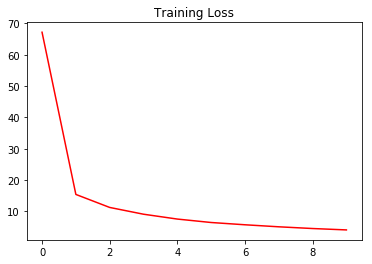

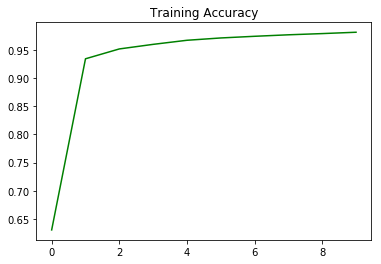

In [17]:
plt.plot(losses, c = 'r')
plt.title('Training Loss')
plt.show()
plt.plot(accs, c = 'g')
plt.title('Training Accuracy')
plt.show()

##Testing the model

In [19]:
acc = 0.0
batches = 0
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx).one_hot(10)
    predictions = model(features)
    acc += accuracy(predictions, labels)
    batches += 1
print(f'Test Accuracy: {acc.asscalar()/batches}')

Test Accuracy: 0.9685509554140127
